<a href="https://colab.research.google.com/github/eikeschuett/IcebergShipDetection/blob/main/Ship_Iceberg_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview



**Topic**: Iceberg and ship detection with satellite imagery

**Goal**: This project is aimed at building an algorithm for the detcetion of ships and icebergs in Sentinel-1 SAR imagery. Desired output is a map, which shows the locations of icebergs, ships and unidentified objects.

**Details**: The dataset used for training is obtained from a Kaggle challenge, [Statoil/C-CORE Iceberg Classifier](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge). Each image has 75x75 pixels with two bands from HH and HV polarisations and contains a ship or an iceberg. This dataset will be used to train a CNN. After training the classification model, we will use Sentinel-1 SAR images to show the "real world application" of our model. The satellite images will be pre-processed with the Sentinel Application Platform (SNAP) Python API. We will then identify bright objects within each satellite image. A 75x75 subset of the radar image will be made for each object and fed into our classification model. Finally, the results will be plotted on a map.

The program is uploaded on a public GitHub repository: [`eikeschuett/IcebergShipDetection`](https://github.com/eikeschuett/IcebergShipDetection)

# Dataset
This project used the satellite SAR imagery provided by Kaggle challeng , [Statoil/C-CORE Iceberg Classifier](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge).
The dataset information is saved in the json file containing the following fields (see Table 1):
* id: the id of the image 
* band_1 & band_2: the flattened image data. Each band has 75x75 pixel values in the list. The values are float numbers with unit being dB with the physical meaning of backscatter coefficient, $\sigma^0$. band_1 and band_2 represent for HH-polarisation and HV polarisation, respectively (see Figure 1 below for having an idea of how the image looks like).
* inc_angle: the incidence angle (see Figure 2). This field has missing data mark as "na", in our project, we gave the "na" a default value of 30°.
* is_iceberg: the target variable, set to 1 if it is an iceberg, and 0 if it is a ship. 

> **Table 1**: A glimpse of `train.json` file <br>

| id |band_1 | band_2 | inc_angle | is_iceberg |
| --------- | ---- | ---------------- | --------------- | ---------------- |
|dfd5f913 |	[-27.878360999999998, -27.15416, -28.668615, -... |	[-27.154118, -29.537888, -31.0306, -32.190483,... |	43.9239 |	0 |
|e25388fd |	[-12.242375, -14.920304999999999, -14.920363, ... |	[-31.506321, -27.984554, -26.645678, -23.76760... |	38.1562 | 0 |
|58b2aaa0 |	[-24.603676, -24.603714, -24.871029, -23.15277... |	[-24.870956, -24.092632, -20.653963, -19.41104... |	45.2859 |	1 |
|4cfc3a18 |	[-22.454607, -23.082819, -23.998013, -23.99805... |	[-27.889421, -27.519794, -27.165262, -29.10350... |	43.8306 |	0 |
|271f93f4 |	[-26.006956, -23.164886, -23.164886, -26.89116... |	[-27.206915, -30.259186, -30.259186, -23.16495... |	35.6256 |	0 |



As the field is_iceberg only exists in `train.json` but not `test.json`, this project only used `train.json` and separated the dataset into training, validation and test datasets with the proportion of $7:2:1$.


In [4]:
%%html
<IMG SRC="https://raw.githubusercontent.com/eikeschuett/IcebergShipDetection/main/image_example.png" border="0"></a>


> **Figure 1**: Example for SAR image with HH and HV polarisations.

In [ ]:
%%html
<IMG SRC="https://earth.esa.int/handbooks/asar/aux-files/ephimg-10418557.gif" border="0"></a>

> **Figure 2**: Illustration of incidence angle (source: [ESA earthnet](https://earth.esa.int/handbooks/asar/CNTR5-5.html)).

# Method


## Normalization

This study applied incidence angle normalization method [(Topouzelis et al., 2016)](https://www.degruyter.com/view/journals/geo/8/1/article-p450.xml?tab_body=abstract) to normalize the backscatter coefficient from band_1 (HH) and band_2 (HV) using:

$\sigma_{\theta, norm}^0=\dfrac{\sigma_\theta^0+(0.766\theta-31.638)}{2}$

where<br>
> $\theta$: incidence angle<br>
> $\sigma^0_\theta$: backscatter coefficient at incidence angle $\theta$<br>



## Band 3 Generation

This project test different combinations of HH and HV polarisations data for generating the 3rd bands. 
Addition (+), subtraction (-), multiplication (\*) and division (/) were applied in the test stage.
Addition calculation $HH + HV$ is also known as the **total backscatter**.

According to [Heiselberg, 2016](https://www.mdpi.com/2072-4292/12/15/2353), the **cross polarisation ratio** $C = HV / (HH+HV)$ is a commonly used spatial feature in Ship-Iceberg Classification. 
Thus, the cross polarisation ratio was also applied in the test stage. 
Figure 3 shows loss and accuracy charts applying different generations of band 3.

Check the program [CNN_test_different_3rd_bands_c.ipynb on CNN_Trail_and_Error branch](https://github.com/eikeschuett/IcebergShipDetection/blob/DNN_Trial_and_Error/CNN_test_different_3rd_bands_c.ipynb).




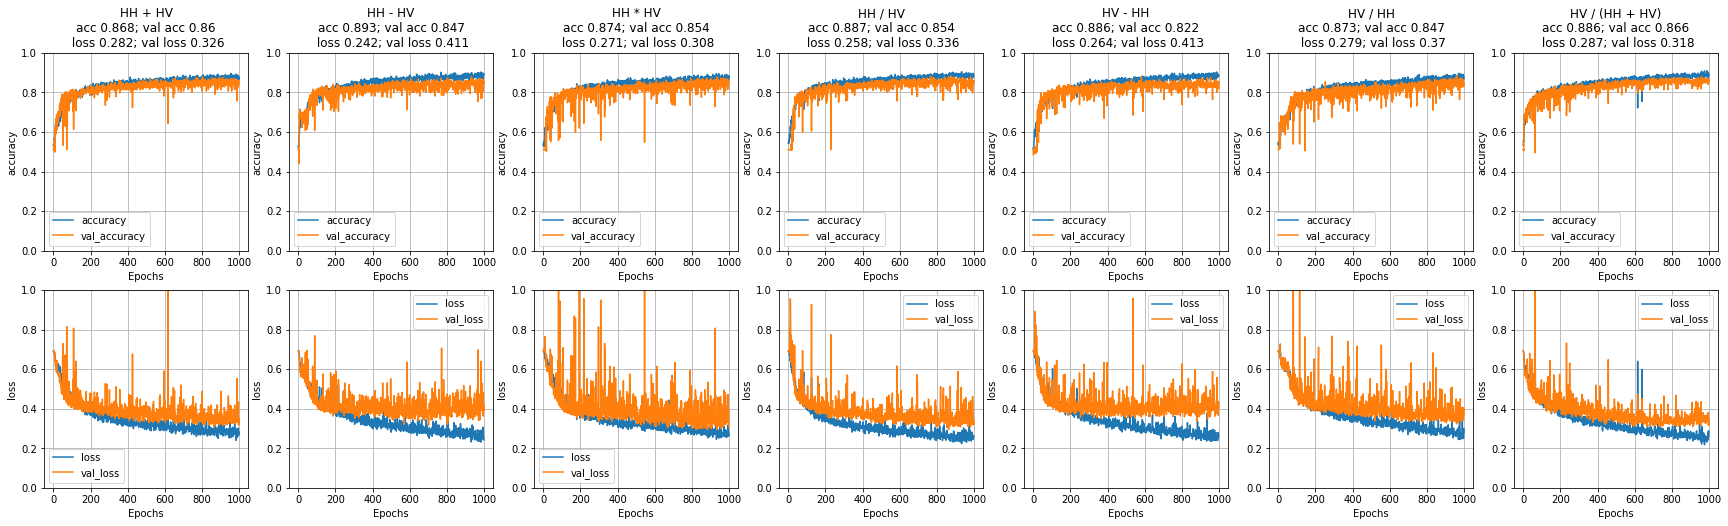
> **Figure 3**: Comparing the training results with different band 3.

Most promising combinations are total backscatter HH+HV and cross polarisation ratio HV/(HH+HV) with the validation accuracies 0.860 and 0.866, respectively.

## Image Denoising
Differrnt filters for initial image denoising have been tested in this projecet.
Figure 4 shows the examples of how filters work on ship images and iceberg images.
Figure 5 shows the loss and accuracy charts applying different filters.

Check the program [CNN_test_different_speckle_filters on CNN_Trail_and_Error branch](https://github.com/eikeschuett/IcebergShipDetection/blob/DNN_Trial_and_Error/CNN_test_different_speckle_filters.ipynb).

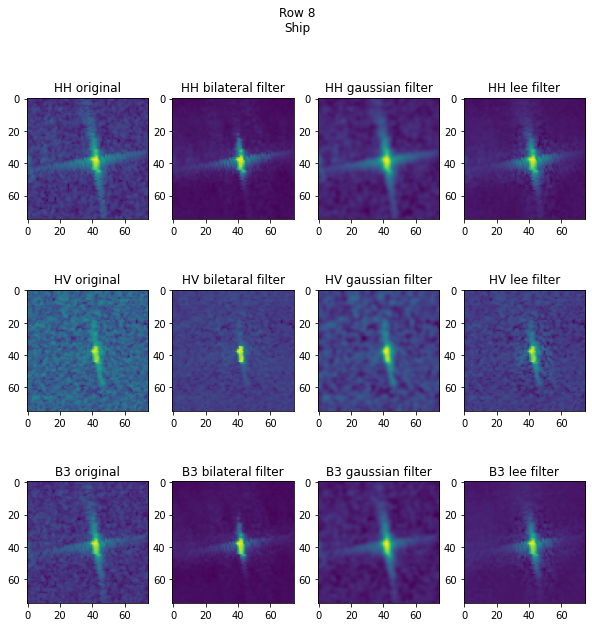

(a) Examples of ship

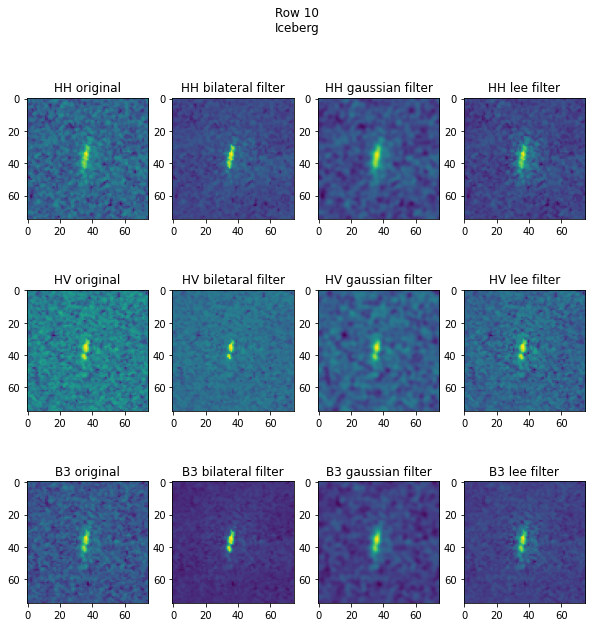

(b) Examples of icebergs

> **Figure 4**: Examples of filterd SAR images.

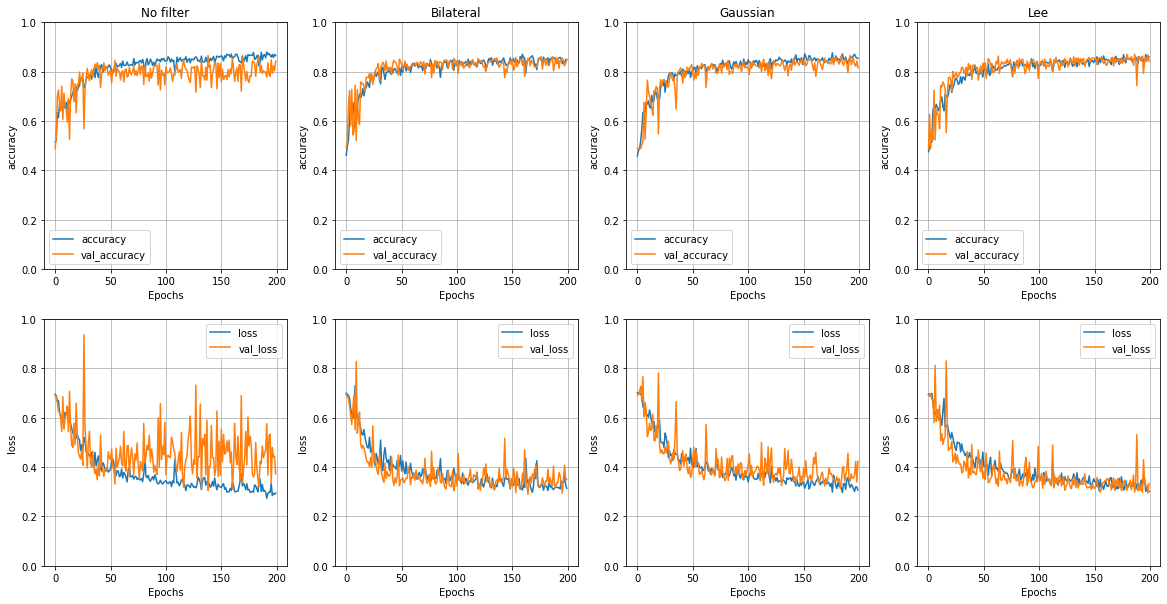

> **Figure 5**: Comparing the training results with different filters: no filter, bilateral filter, Gaussian filter and Lee filter.

There are not much differecne between the training results, but bilateral filter and Lee filter appear to denoise best. 
As bilateral filter is more time-consuming, this project applied **Lee filter**.

## Optimizer Decision
This project has tested the loss function Binary cross entropy with different optimizers, RMSProp, Adam, SGD and SGD with nesterov momentum, on training our ship-iceberg classifier.
Figure 6 shows the loss and accuracy charts applying different optimizers.

Check the program [CNN_test_different_optimizers.ipynb on the CNN_Trail_and_Error branch](https://github.com/eikeschuett/IcebergShipDetection/blob/DNN_Trial_and_Error/CNN_test_different_speckle_filters.ipynb).

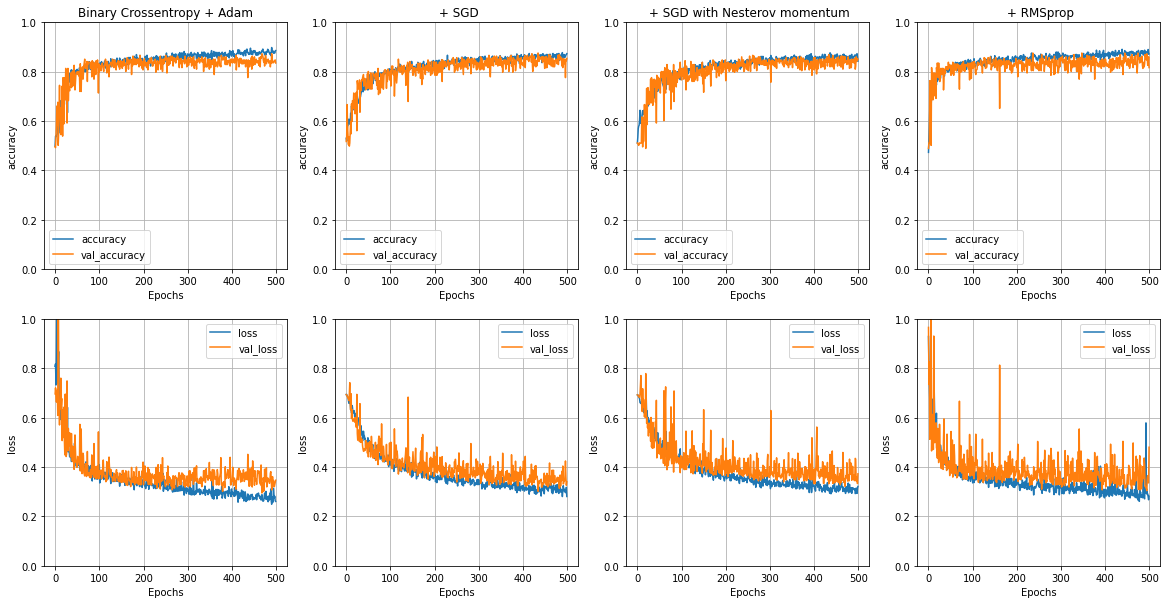

> **Figure 6**: Comparing the training results with different optimizers: Adam, SGD, SGD with nesterov momentum and RMSProp.




The curves of the loss of SGD+Nesterov and RMSprop is quite jaggy. 
Adam learns fast in the beginning but shows overfitting after approx. 250 to 300 epochs. 
SGD needs more epochs to get nice results, but its curves look the best after 500 epochs.
Table 2 shows the test accuracies with different optimizers

> **Table 2**: Test accuracies with different optimizers

|               | Adam |  SGD | SGD+Nesterov | RMSprop |
|---------------|------|------|--------------|---------|
| Test Accuracy | 0.83 | 0.87 |     0.89     |   0.86  |

Experiences with other models show that Adam is more stable than SGD. This project used **Adam** and paid attention to potential overfitting.

# Outline

1. Download the Kaggle dataset to Google Drive with Kaggle API
2. Build up the CNN architecture for training
3. Train the model
4. Test with real world data

# Download the Kaggle dataset to Google Drive

Following the steps: https://www.kaggle.com/general/74235

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/

Go to your account in Kaggle, scroll to API section and click  on "Create New API Token". Then, the file `kaggle.json` will be downloaded into your local drive, upload it with `files.upload()`.

In [ ]:
from google.colab import files
files.upload()

Make directory named kaggle and copy `kaggle.json` file there.

In [ ]:
!mkdir -p kaggle
!mv kaggle.json kaggle
%cd kaggle/

Download the data to the directory `/content/drive/MyDrive/kaggle/data`

In [ ]:
!mkdir -p data
%cd data
!kaggle competitions download -c carvana-image-masking-challenge

Unzip the *.7z file with the build-in command.

In [ ]:
!7z e test.json.7z 
!7z e train.json.7z 
!7z e sample_submission.csv.7z 

Folder Structure on Google Drive
```
MyDrive/
    kaggle/
        data/
            train.json.7z
            test.json.7z
            sample_submission.csv.7z
            train.json
            test.json
            sample_submission.csv
```

Note that `test.json` data doesn't contain the label `is_iceberg`, so this project only use `train.json` and split the data into training, validation and test data.

# Build up the CNN Architecture

Import the libraries

In [ ]:
import numpy as np # linear algebra
np.random.seed(666)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from subprocess import check_output
from matplotlib import pyplot
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from tensorflow.keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
data = pd.read_json('/content/drive/MyDrive/kaggle/data/train.json')

data.inc_angle = data.inc_angle.replace('na', np.nan)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_img1(sig_nought, vmin, vmax):
    """
    :type sig_nought: np.ndarray(np.float)
    """
    plt.imshow(sig_nought, cmap = plt.cm.Greys, 
                    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax))

    cbar = plt.colorbar()
    cbar.set_label('[dB]')
    plt.show()

def plot_img2(sig_nought, sig_nought_n):
    """
    :type sig_nought: np.ndarray(np.float)
    :type sig_nought_n: np.ndarray(np.float)
    """
    vmax=np.ceil(max(np.max(sig_nought),np.max(sig_nought_n)))
    vmin=np.floor(min(np.min(sig_nought),np.min(sig_nought_n)))

    fig, axes = plt.subplots(nrows=1, ncols=2)
    im = axes[0].imshow(sig_nought, cmap = plt.cm.Greys, 
                   norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax))
    axes[1].imshow(sig_nought_n, cmap = plt.cm.Greys, 
                   norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax))
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.25, 0.05, 0.5])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('[dB]')
    plt.show()


In [ ]:
def normalize(sig_nought, inc_angle, default_inc = None):
    """
    :type sig_nought: np.ndarray(np.float)
    :type inc_angle: float
    :rtype: np.ndarray(np.float)
    """
    
    if np.isnan(inc_angle):
        if default_inc != None:
            inc_angle = default_inc
            sig_nought_n = (sig_nought + 0.766 * inc_angle - 31.638) / 2
        else:
            sig_nought_n = sig_nought
    else:
        sig_nought_n = (sig_nought + 0.766 * inc_angle - 31.638) / 2

    return sig_nought_n


In [ ]:
def lee_filter(img, size):
    # From here: https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

In [ ]:
def prepare_data(data):
    x_angle = np.array(data["inc_angle"])

    # Get the labels (y-values)
    labels = np.array(data["is_iceberg"])

    # Create empty list for the images
    imgs = []
    cpr = []
    for i, row in data.iterrows():
        # Reshape list to image
        hh  = np.reshape(row["band_1"], (75, 75))
        hv  = np.reshape(row["band_2"], (75, 75))

        # normalize hh and hv using inc_angle (x_angle[i])
        # with default inc_angle = 30  # if np.isnan(inc_angle)
        hh = normalize(hh, row["inc_angle"], 30)
        hv = normalize(hv, row["inc_angle"], 30)

        # total backscatter = hh + hv
        b3 = hh + hv
        # cross polarisation ratio = hv / (hh+hv)
        #c3 = hv / b3

        # 
        hh = lee_filter(hh, 20)
        hv = lee_filter(hv, 20)
        b3 = lee_filter(b3, 20)      
        #c3 = lee_filter(c3, 20) 
          
        # Rescale images between 0 and 1 for faster convergence rate
        hh = (hh - hh.min())/(hh.max()-hh.min())
        hv = (hv - hv.min())/(hv.max()-hv.min())
        b3 = (b3 - b3.min())/(b3.max()-b3.min())
        
        # Stack the bands and append them to imgs
        #imgs.append(np.dstack((hh, hv, b3, c3)))
        imgs.append(np.dstack((hh, hv, b3)))
    
    
    # Split dataset into training (70%) and validation (30 %)                             
    x_train, x_val, y_train, y_val = train_test_split(imgs, labels,
                                                     test_size=0.3,
                                                     random_state=0)
    # Then split validation dataset into validation (20 %) and testing (10 %)
    x_val, x_test, y_val, y_test = train_test_split(x_val, y_val,
                                                     test_size=(1/3),
                                                     random_state=0)                               
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    x_val = np.array(x_val)
    
    return x_train, x_val, x_test, y_train, y_val, y_test

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = prepare_data(data)

print("Number of samples for training: %i (%.2f%%)"%(len(x_train), round(len(x_train)/len(data)*100)))
print("Number of samples for validation: %i (%.2f%%)"%(len(x_val), round(len(x_val)/len(data)*100)))
print("Number of samples for testing: %i (%.2f%%)"%(len(x_test), round(len(x_test)/len(data)*100)))

Number of samples for training: 1122 (70.00%)
Number of samples for validation: 321 (20.00%)
Number of samples for testing: 161 (10.00%)


In [ ]:
batch_size = 32
gen = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

gen_flow = gen.flow(x_train, y_train, batch_size = batch_size, seed = 666)


In [ ]:
def create_model(optimizer):
    ac_fct      = "relu"
    #momentum    = 0

    input_img   = Input(shape=(75, 75, 3), name="X_img")
    #input_img   = Input(shape=(75, 75, 4), name="X_img")
    #input_angle = Input(shape=[1], name="angle")

    #cnn = BatchNormalization()(input_img)
    cnn = Conv2D(16, kernel_size=(3,3), activation = "relu")(input_img)
    #cnn = Conv2D(16, kernel_size=(3,3), activation = "relu")(cnn)
    cnn = MaxPooling2D((2,2))(cnn)
    cnn = Dropout(0.1) (cnn)

    cnn = Conv2D(32, kernel_size=(3,3), activation = "relu")(cnn)
    #cnn = Conv2D(32, kernel_size=(3,3), activation = "relu")(cnn)
    cnn = MaxPooling2D((2,2))(cnn)
    cnn = Dropout(0.1)(cnn)

    cnn = Conv2D(64, kernel_size=(3,3), activation = "relu")(cnn)
    #cnn = Conv2D(64, kernel_size=(3,3), activation = "relu") (cnn)
    cnn = MaxPooling2D((2,2))(cnn)
    cnn = Dropout(0.1)(cnn)  

    cnn = Conv2D(128, kernel_size=(3,3), activation = "relu")(cnn)
    cnn = Conv2D(128, kernel_size=(3,3), activation = "relu") (cnn)
    cnn = MaxPooling2D((2,2))(cnn)
    cnn = Dropout(0.1)(cnn)  
    

    cnn = GlobalMaxPooling2D()(cnn)

    #angle = BatchNormalization(momentum=0)(input_angle)
    #angle = Lambda(lambda x: (x - 25)/(45-25))(input_angle)
    
    #concat = (Concatenate()([cnn, angle]))

    #dense = Dense(32, activation="relu") (concat)
    dense = Dense(32, activation="relu")(cnn)
    # dense = BatchNormalization() (dense)
    # dense = Dropout(0.2)(dense)
    
    #dense = Dense(128, activation="relu") (dense)
    #dense = BatchNormalization() (dense)
    #dense = Dropout(0.2)(dense)

    #dense = Dense(128, activation="relu") (dense)
    #dense = BatchNormalization() (dense)
    #dense = Dropout(0.2)(dense)

    output = Dense(1, activation="sigmoid")(dense)

    #model = Model([input_img, input_angle], output)
    model = Model(input_img, output)
    #optimizer = Adam(lr=0.1, epsilon=1e-08, decay=0.0)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

epochs = 150
# learning_rate = 0.1
# decay_rate = learning_rate / epochs
# momentum = 0.8
# sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

# from keras.optimizers import Adadelta
model = create_model(optimizer = Adam())
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_img (InputLayer)           [(None, 75, 75, 3)]       0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 73, 73, 16)        448       
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 36, 36, 16)        0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 34, 34, 32)        4640      
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 17, 17, 32)        0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 17, 17, 32)        0  

# Train the Model

In [ ]:
history = model.fit(gen_flow, validation_data=(x_val, y_val),
                    steps_per_epoch=len(x_train) / batch_size, epochs=epochs)


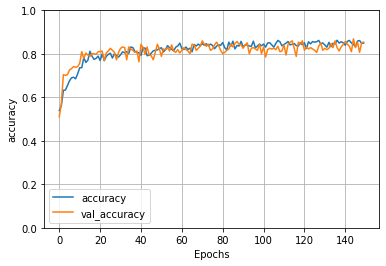

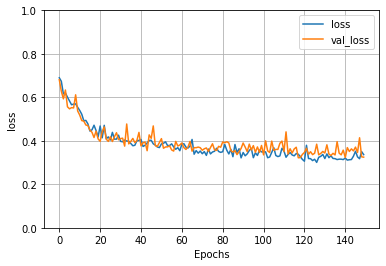

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.ylim([0,1])
  plt.grid()
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
results = model.evaluate(x_test, y_test)

6/6 [==============================] - 0s 3ms/step - loss: 0.3184 - accuracy: 0.8571


In [ ]:
model.save("/concent/drive/MyDrive/kaggle/model_normalize.hd5")

INFO:tensorflow:Assets written to: /concent/drive/MyDrive/kaggle/model_normalize.hd5/assets


# Test with real world data